In [1]:
# imports 
import os
import json
import operator
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import random

# Players
BotHash = "DF3669486BD420D03A5628070839BB37"
SB = 10
Players = [
     {
        'Name': 'Bold',
        'games': 'Bold'
    },
    {
        'Name': 'FoldMan',
        'games': 'FoldMan'
    },
    {
        'Name': 'Fish',
       'games': 'Fish'
    },
    {
        'Name': 'Random',
        'games': 'Random',
    },
    {
        'Name': 'HonestMan',
        'games':'HonestMan',
    }
]

def prettyPrint(*arguments):
    out = ''
    for arg in arguments:
        space = (30-len(arg)) * " "
        out += arg + space
    print(out)
    
# Load file paths of player games.
def LoadPlayerGames(player):
    #return [os.path.join(r,file) for r,d,f in os.walk(player['games']) for file in f]
    return [os.path.join(player['games'],f) for f in os.listdir(player['games']) if not f.startswith('.')]

# Load game as json object.
def LoadGame(path):
    with open(path) as f:
        g = json.load(f)
        if g["BotHash"] != BotHash:
            raise Exception("BotHash does not match: " + g["BotHash"])
        return g

# Get player result from game (W,D,L)
def GetGameResultForPlayer(game, playerName):
    results = game["Results"]
    maxStack = 0
    hasMax = []
    # find max stack
    for result in results:
        if maxStack < result["Stack"]:
            maxStack = result["Stack"]
            hasMax= [result["Player"]["Name"]]
        elif maxStack == result["Stack"]:
            hasMax.append(result["Player"]["Name"])
    # find player result
    if playerName in hasMax:
        if len(hasMax) > 1:
            return 'D'
        else:
            return 'W'
    return 'L'
            
# Get player results against opponent
def GetPlayerGamesResults(playerName, opponent):
    won = 0
    lost = 0
    drew = 0
    files = LoadPlayerGames(opponent)
    for file in files:
        game = LoadGame(file)
        result = GetGameResultForPlayer(game, playerName)
        if result == 'W':
            won += 1
        elif result == 'D':
            drew += 1
        elif result == 'L':
            lost += 1
        else:
            raise Exception("Error :(")
    return (won, drew, lost)

# Get player result from round (W,D,L)
def GetRoundResultForPlayer(r, playerName):
    results = r["Winner"]
    winners = len(results)
    won = False
    for result in results:
        if playerName == result["Name"]:
            won = True
            break
    if won:
        if winners > 1:
            return 'D'
        else:
            return 'W'
    return 'L'

# Get player round results from game
def GetRoundResultsForPlayer(game, playerName):
    won = 0
    lost = 0
    drew = 0
    for r in game["Rounds"]:
        result = GetRoundResultForPlayer(r, playerName)
        if result == 'W':
            won += 1
        elif result == 'D':
            drew += 1
        elif result == 'L':
            lost += 1
        else:
            raise Exception("Error :(")
    return (won, drew, lost)

# Get player round results against an opponent
def GetPlayerRoundResults(playerName, opponent):
    won = 0
    lost = 0
    drew = 0
    files = LoadPlayerGames(opponent)
    for file in files:
        game = LoadGame(file)
        w,d,l = GetRoundResultsForPlayer(game, playerName)
        won += w
        drew += d
        lost += l
    return (won, drew, lost)

def GetPlayerPlayingStyle(opponent,playerName):
    playerModel = {
        'LooseAggressive': 0,
        'LoosePassive': 0,
        'TightAggressive': 0,
        'TightPassive': 0,
        'Balanced' : 0,
    }
    opponentModel = {
        'LooseAggressive': 0,
        'LoosePassive': 0,
        'TightAggressive': 0,
        'TightPassive': 0,
        'Balanced' : 0,
    }
    
    files = LoadPlayerGames(opponent)
    for file in files:
        game = LoadGame(file)
        models = game["PlayerModels"]
        for m in models:
            if m["Player"]["Name"] == playerName:
                playerModel[m["PlayingStyle"]] +=1
            if m["Player"]["Name"] == opponent["Name"]:
                opponentModel[m["PlayingStyle"]] +=1
    return (max(playerModel.items(), key=operator.itemgetter(1))[0], max(opponentModel.items(), key=operator.itemgetter(1))[0])

    
def GetWPH(playerName, opponent, rn):
    stackSum = 0
    initStack = 0
    files = LoadPlayerGames(opponent)
    for file in files:
        game = LoadGame(file)
        for r in game["Results"]:
            if playerName == r["Player"]["Name"]:
                stackSum += r["Stack"]
                initStack += r["InitialStack"]
                break
    return (stackSum-initStack)/rn


def GetFWPHForPlayer(game, playerName):
    loss = 0
    rn = len(game["Rounds"])
    for r in game["Rounds"]:
        sbp = r["SmallBlindPosition"]
        bbp = r["BigBlindPosition"]
        if r["Players"][sbp]["Name"] == playerName:
            loss -= SB
        if r["Players"][bbp]["Name"] == playerName:
            loss -= SB * 2
    return loss/rn

def GetFWPH(playerName, opponent):
    files = LoadPlayerGames(opponent)
    fwphSum = 0
    gn = len(files)
    for file in files:
        game = LoadGame(file)
        fwphSum += GetFWPHForPlayer(game, playerName)
    return fwphSum/gn   

def AdjustedWPH(wph, fwph):
    return wph - fwph


# heat map
def DrawWeightTable(playerModel, name):
    csvStringIO = StringIO(playerModel["WeightTable"])
    df = pd.read_csv(csvStringIO, header = None, names=["A", "K", "Q", "J", "T", "9", "8", "7", "6", "5", "4", "3", "2"])
    # Displaying dataframe as an heatmap
    # with diverging colourmap as Greys
    plt.imshow(df, cmap="Greys",vmin=0,vmax=1) 

    # Displaying a color bar to understand
    # which color represents which range of data
    plt.colorbar()

    # ticks style
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False

    plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
    plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

    # title
    plt.xlabel("Hand Strength Adjustment metrix " + name)

    # Assigning labels of x-axis 
    # according to dataframe
    plt.xticks(range(len(df)), df.columns)

    # Assigning labels of y-axis 
    # according to dataframe
    plt.yticks(range(len(df)), ["A", "K", "Q", "J", "T", "9", "8", "7", "6", "5", "4", "3", "2"])


    # Displaying the figure
    plt.show()


        
# print results
def PrintResultOf(playerName):
    for player in Players:
        prettyPrint("Results against:", player["Name"])
        n = len(LoadPlayerGames(player))
        w,d,l = GetPlayerGamesResults(playerName, player)
        # game states
        prettyPrint("number of games:",str(n))
        prettyPrint("number of games won:", str(w) , "{:.1f}".format(w*100/n) + "%")
        prettyPrint("number of games drew:", str(d), "{:.1f}".format(d*100/n) + "%")
        prettyPrint("number of games lost:", str(l), "{:.1f}".format(l*100/n) + "%")
        # round states
        rw,rd,rl = GetPlayerRoundResults(playerName, player)
        rn = rw+rd+rl
        prettyPrint("number of rounds:",str(rn))
        prettyPrint("number of rounds won:", str(rw) , "{:.1f}".format(rw*100/rn) + "%")
        prettyPrint("number of rounds drew:", str(rd), "{:.1f}".format(rd*100/rn) + "%")
        prettyPrint("number of rounds lost:", str(rl), "{:.1f}".format(rl*100/rn) + "%")
        # wph
        wph = GetWPH(playerName, player, rn)
        fwph = GetFWPH(playerName, player)
        prettyPrint("WPH:", "{:.1f}".format(wph))
        prettyPrint("FWPH:", "{:.1f}".format(fwph))
        prettyPrint("AWPH:", "{:.1f}".format(AdjustedWPH(wph, fwph)))
        # playing style
        ps, os = GetPlayerPlayingStyle(player,playerName)
        prettyPrint(playerName + " Playing Style:", ps)
        prettyPrint(player["Name"] + " Playing Style:", os)
        # player models
        files = LoadPlayerGames(player)
        game = LoadGame(random.choice(files))
        for model in game["PlayerModels"]:
            #if model["Player"]["Name"] == playerName:
            #    continue
            DrawWeightTable(model,model["Player"]["Name"])
        print('-------------------------------------------------------------')
        
        
# postflop rounds
def HasFolded(r, playerName):
    for a in r["History"]:
        if a["PlayerName"] == playerName and a["Type"] == "Fold":
            return True
    return False

def HasFoldedPreflop(r, playerName):
    for a in r["History"]:
        if a["PlayerName"] == playerName and a["Type"] == "Fold" and a["Stage"] == "Preflop":
            return True
    return False

def GetPostFlopRoundsFromGame(game, playerName):
    rs = []
    for r in game["Rounds"]:
        if not HasFoldedPreflop(r, playerName):
            rs.append(r)
    return rs

def GetPostFlopFoldsFromGame(game, playerName):
    rs = []
    for r in game["Rounds"]:
        if not HasFoldedPreflop(r, playerName):
            if HasFolded(r, playerName):
                rs.append(r)
    return rs


Results against:              Bold                          
number of games:              100                           
number of games won:          38                            38.0%                         
number of games drew:         0                             0.0%                          
number of games lost:         62                            62.0%                         
number of rounds:             3237                          
number of rounds won:         110                           3.4%                          
number of rounds drew:        0                             0.0%                          
number of rounds lost:        3127                          96.6%                         
WPH:                          -7.1                          
FWPH:                         -14.8                         
AWPH:                         7.7                           
PokerShark Playing Style:     TightPassive                  
Bold Playing Style:        

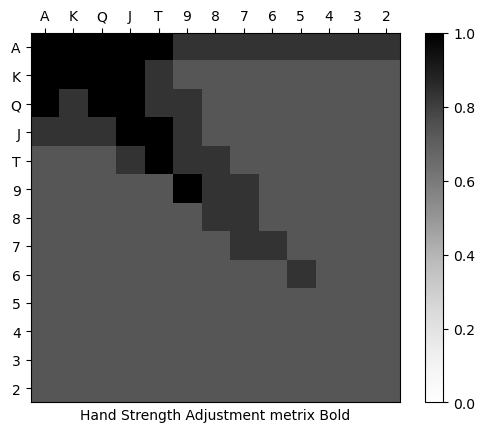

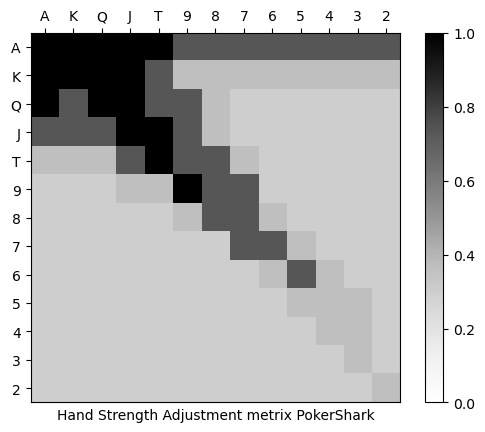

-------------------------------------------------------------
Results against:              FoldMan                       
number of games:              100                           
number of games won:          100                           100.0%                        
number of games drew:         0                             0.0%                          
number of games lost:         0                             0.0%                          
number of rounds:             10000                         
number of rounds won:         6256                          62.6%                         
number of rounds drew:        0                             0.0%                          
number of rounds lost:        3744                          37.4%                         
WPH:                          3.8                           
FWPH:                         -15.0                         
AWPH:                         18.8                          
PokerShark Playing Style: 

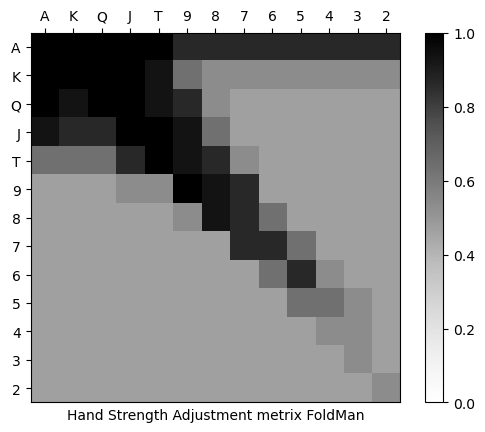

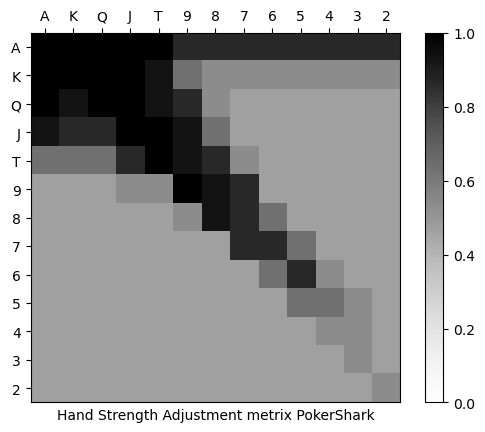

-------------------------------------------------------------
Results against:              Fish                          
number of games:              100                           
number of games won:          68                            68.0%                         
number of games drew:         0                             0.0%                          
number of games lost:         32                            32.0%                         
number of rounds:             3385                          
number of rounds won:         1511                          44.6%                         
number of rounds drew:        21                            0.6%                          
number of rounds lost:        1853                          54.7%                         
WPH:                          11.0                          
FWPH:                         -14.8                         
AWPH:                         25.8                          
PokerShark Playing Style: 

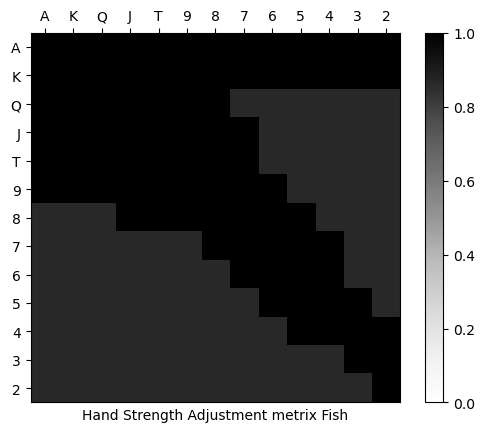

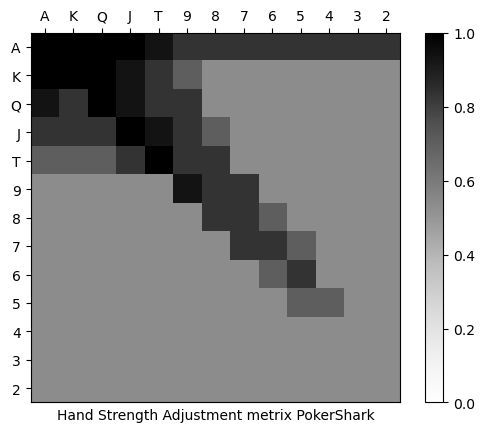

-------------------------------------------------------------
Results against:              Random                        
number of games:              99                            
number of games won:          47                            47.5%                         
number of games drew:         0                             0.0%                          
number of games lost:         52                            52.5%                         
number of rounds:             4534                          
number of rounds won:         1272                          28.1%                         
number of rounds drew:        0                             0.0%                          
number of rounds lost:        3262                          71.9%                         
WPH:                          -0.3                          
FWPH:                         -14.9                         
AWPH:                         14.6                          
PokerShark Playing Style: 

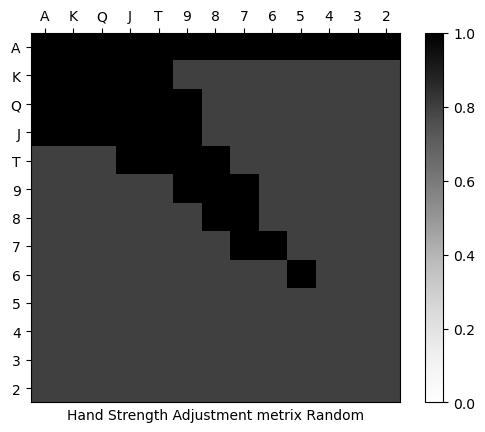

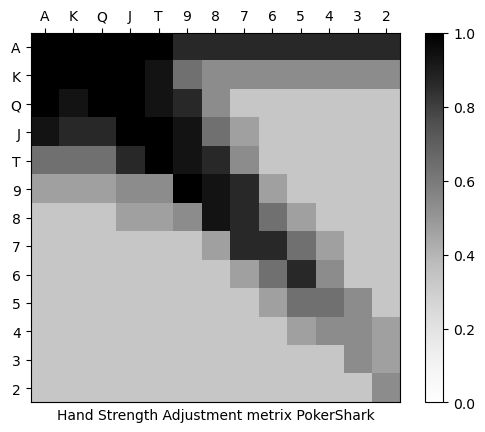

-------------------------------------------------------------
Results against:              HonestMan                     
number of games:              100                           
number of games won:          17                            17.0%                         
number of games drew:         0                             0.0%                          
number of games lost:         83                            83.0%                         
number of rounds:             9340                          
number of rounds won:         3670                          39.3%                         
number of rounds drew:        3                             0.0%                          
number of rounds lost:        5667                          60.7%                         
WPH:                          -1.6                          
FWPH:                         -15.0                         
AWPH:                         13.4                          
PokerShark Playing Style: 

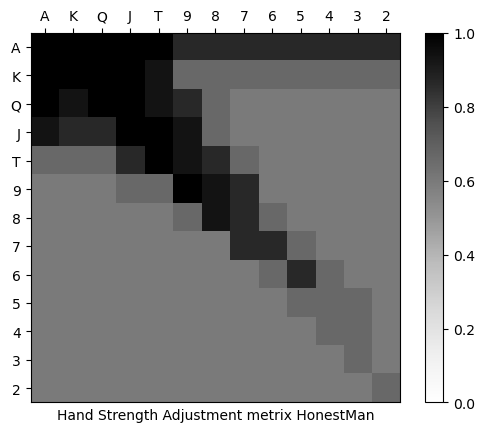

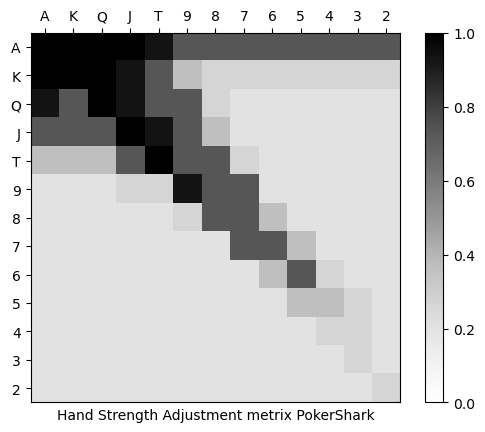

-------------------------------------------------------------


In [3]:
PrintResultOf('PokerShark')